In [2]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,453 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

###(3) Download best checkpoints


In [3]:
# Download the best checkpoint from Tesseract github
!git clone https://github.com/tesseract-ocr/tessdata_best.git

Cloning into 'tessdata_best'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 254 (delta 0), reused 2 (delta 0), pack-reused 250
Receiving objects: 100% (254/254), 1.30 GiB | 30.81 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (167/167), done.


In [4]:
!ls /content/tessdata_best/*.traineddata | wc -l

124


###(4)Extract text from image using commandline

In [5]:
#This a function that helps you to show the image on your notebook
from matplotlib import pyplot as plt
from PIL import Image
def show_image(img):
    im=Image.open(img)
    print(im.width, im.height, im.mode, im.format, type(im))
    return im

###(5) Improve the model's output accurecy.

**Method1: clean the image and convert it to white and black; find best rotation angle**



In [18]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from scipy.ndimage import interpolation as inter
#Find best rotation angle
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
#clean the image and convert it to white and black image
def image_cleaner(input_file):
  # input_file = sys.argv[1]
  img = im.open(input_file)
  # convert to binary
  wd, ht = img.size
  pix = np.array(img.convert('1').getdata(), np.uint8)
  bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)
  # plt.imshow(bin_img, cmap='gray')
  # plt.savefig('binary.png')
  
  delta = 1
  limit = 5
  angles = np.arange(-limit, limit+delta, delta)
  scores = []
  for angle in angles:
      hist, score = find_score(bin_img, angle)
      scores.append(score)
  best_score = max(scores)
  best_angle = angles[scores.index(best_score)]
  print('Best angle:', best_angle)
  # correct skew
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
  img = im.fromarray((255 * data).astype("uint8")).convert("RGB")
  img.save(input_file[:-3]+'png', dpi=(300, 300))


**Method2: enhance the iamge quality using Open CV library and change dpi to 600**


In [11]:
import glob, os
import cv2
import numpy as np
from PIL import Image
def enhance_image(f):
  print (f)
  # os.system("python clean_image.py "+f)
  image = cv2.imread(f)
  # g = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # print (g.shape) 
  # cv2.imshow('Gray image', gray)
  image = cv2.resize(image, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kernel = np.ones((1, 1), np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)
  image = cv2.erode(image, kernel, iterations=1)
  cv2.threshold(cv2.GaussianBlur(image, (5, 5), 0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # cv2.threshold(cv2.bilateralFilter(image, 5, 75, 75), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # cv2.threshold(cv2.medianBlur(image, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  cv2.adaptiveThreshold(cv2.GaussianBlur(image, (5, 5), 0), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
  # cv2.adaptiveThreshold(cv2.bilateralFilter(image, 9, 75, 75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
  # cv2.adaptiveThreshold(cv2.medianBlur(image, 3), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)  
  RGBimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  PILimage = Image.fromarray(RGBimage)
  PILimage.save(f[:-4]+'_enhanced_600dpi.png',dpi=(600, 600))

###(5)Using Python wrapper (pytesseract)
- More details about the wrapper could be found on https://pypi.org/project/pytesseract/


In [8]:
!pip install pytesseract

     |████████████████████████████████| 4.3 MB 5.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


**Parameters**

`image_to_data(image, lang=None, config='', nice=0, output_type=Output.STRING, timeout=0, pandas_config=None)`



1.   `image` Object or String - PIL Image/NumPy array or file path of the image to be processed by Tesseract. If you pass object instead of file path, pytesseract will implicitly convert the image to RGB mode.
2.   `lang` String - Tesseract language code string. Defaults to eng if not specified! Example for multiple languages: lang='eng+fra'
2.  `config` String - Any additional custom configuration flags that are not available via the pytesseract function. For example: config='--psm 6'
2.  `nice` Integer - modifies the processor priority for the Tesseract run. Not supported on Windows. Nice adjusts the niceness of unix-like processes.
2.  `output_type` Class attribute - specifies the type of the output, defaults to string. For the full list of all supported types, please check the definition of pytesseract.Output class.
2.  `timeout` Integer or Float - duration in seconds for the OCR processing, after which, pytesseract will terminate and raise RuntimeError.
2.  `pandas_config` Dict - only for the Output.DATAFRAME type. Dictionary with custom arguments for pandas.read_csv. Allows you to customize the output of image_to_data. 



In [9]:
import pytesseract

In [1]:
!wget https://raw.githubusercontent.com/UBC-NLP/OCR/main/samples/Sample%20CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA

--2022-03-10 00:43:04--  https://raw.githubusercontent.com/UBC-NLP/OCR/main/samples/Sample%20CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132285 (129K) [image/jpeg]
Saving to: ‘Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA’

Sample CI44_WillieM 100%[===================>] 129.18K  --.-KB/s    in 0.02s   

2022-03-10 00:43:04 (5.99 MB/s) - ‘Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA’ saved [132285/132285]



551 756 RGB JPEG <class 'PIL.JpegImagePlugin.JpegImageFile'>


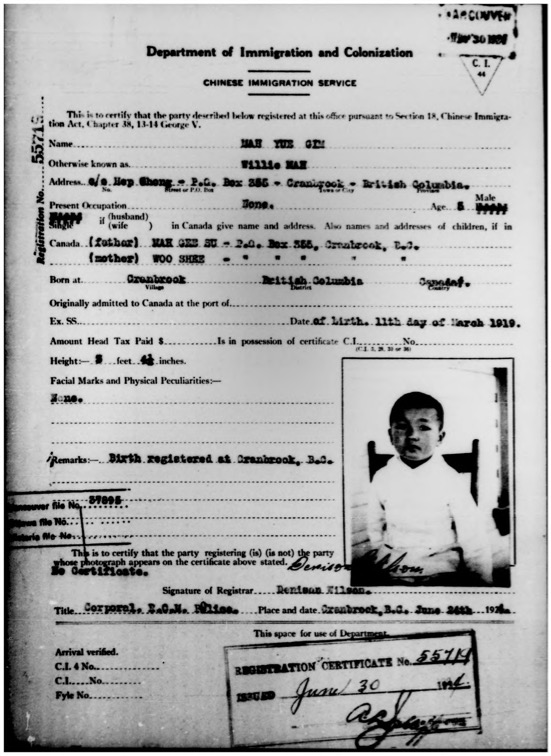

In [6]:
image="/content/Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA"
show_image(image)

In [10]:
tessdata_dir_config = r'--tessdata-dir "/content/tessdata_best"'
text = pytesseract.image_to_string(image, lang='eng', config=tessdata_dir_config)
print (text)

   
   
   
    
   
   
 
   
     
   

Department of Immigration and Colonization

 

oo Thc ce gaat vo Seti 1, Chines Vig

 

Cone {fuber). JAR G53 30 = 2400 Bx. 208, Srvatecar, Te

=
8
$ x
|= dl
(We™) in Canad give mame amd adie. Aes names sd sirens of chibi, if fn
k (mother) woo SHEE = %  ®

 

tote Smatate
Ongnaly smite to Canad tthe ort of... A

Es. Duel? Mzth. 112% tag of Jared 19.
Amount Hest Tax Pst S...._...._.1n in pnmcwion of cic C1 Yo.

Height Beet 4 chen

  

Facil Marks and Physic Pecalsites—

 

Lie EL ve



In [17]:
enhance_image("/content/Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA")

/content/Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJJHEA


661 907 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>


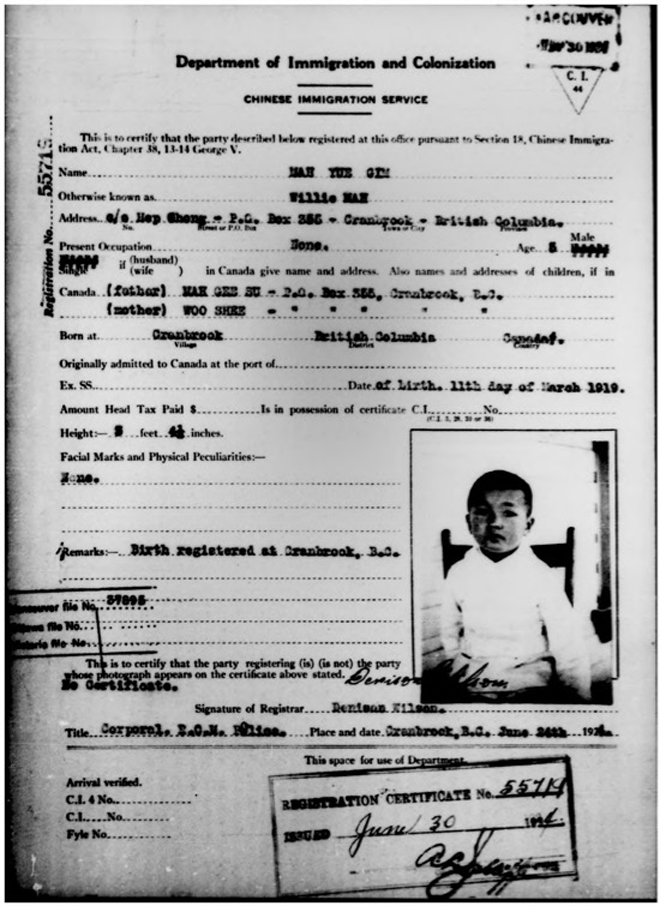

In [14]:
enhanced_image = "/content/Sample CI44_WillieMAH.jpg?token=GHSAT0AAAAAABSBHXZSYBUHRZ67OAQCH5KEYRJ_enhanced_600dpi.png"
show_image(enhanced_image)

In [13]:
tessdata_dir_config = r'--tessdata-dir "/content/tessdata_best"'
text = pytesseract.image_to_string(enhanced_image, lang='eng', config=tessdata_dir_config)
print (text)

 

Department of Immigration and Colonization
CHINESE IMMIGRATION SERVICE

5% Name... ms ws om

 —

4

nate
Address 0/9. Jiup Gong » 2oGo Box 386 >

 

 

& Mate
HIF TE, cmt sm met tm me cee 4
§ cmon (tether) pop Ca , Tele

.. l=ther) woo suERE .

Bon at. Oresbeock 4 arya. Semtats
Originally admitted to Canada at the port of...

Buss 3 1182 Zag of Jared 1019.

ax Pad 8. oe pe ere Cr
Height:— B feet. 4 inches.

Facial Marks and Physical Peculisrites:—
Hone.

us
er Crasigock v Brivieh Goluble.
Tome.

    

Teaecouvin’
owe

ee

 



Best angle: 0
551 756 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>


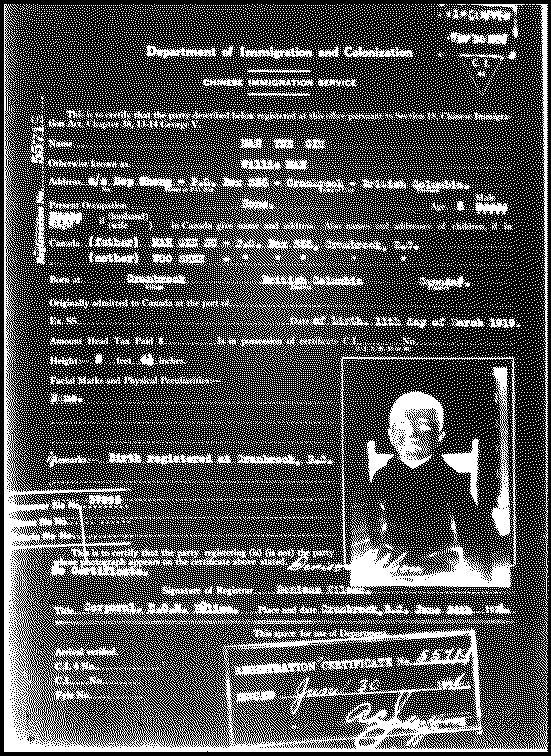

In [20]:
image_cleaner("Sample CI44_WillieMAH.jpg")
black_image = "/content/Sample CI44_WillieMAH.png"
show_image(black_image)

In [21]:
text = pytesseract.image_to_string(enhanced_image, lang='eng', config=tessdata_dir_config)
print (text)

 

Department of Immigration and Colonization
CHINESE IMMIGRATION SERVICE

5% Name... ms ws om

 —

4

nate
Address 0/9. Jiup Gong » 2oGo Box 386 >

 

 

& Mate
HIF TE, cmt sm met tm me cee 4
§ cmon (tether) pop Ca , Tele

.. l=ther) woo suERE .

Bon at. Oresbeock 4 arya. Semtats
Originally admitted to Canada at the port of...

Buss 3 1182 Zag of Jared 1019.

ax Pad 8. oe pe ere Cr
Height:— B feet. 4 inches.

Facial Marks and Physical Peculisrites:—
Hone.

us
er Crasigock v Brivieh Goluble.
Tome.

    

Teaecouvin’
owe

ee

 

